# American Time Use Survery (ATUS) data

[Reference document](https://www.bls.gov/tus/atusintcodebk18.pdf)

[Activity lexicode reference](https://www.bls.gov/tus/lexiconwex2018.pdf)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

_data_folder = os.path.join(os.getcwd(), 'data')

In [2]:
df_summary = pd.read_csv(
    os.path.join(_data_folder, 'atussum-2018', 'atussum_2018.dat'))
df_summary.head()

,TUCASEID,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20180101180006,9.456372e+06,-1,42,1,40,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
1,20180101180021,4.010486e+06,-1,58,1,39,1,2,1,5,...,0,0,0,0,0,0,0,0,0,0
2,20180101180025,3.519394e+07,-1,65,1,37,2,2,1,5,...,0,0,0,0,0,0,0,0,0,0
3,20180101180054,2.251398e+06,-1,72,1,40,2,2,1,5,...,0,0,0,0,0,4,0,0,0,0
4,20180101180060,1.029459e+06,-1,66,2,40,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_response = pd.read_csv(
    os.path.join(_data_folder, 'atusresp-2018', 'atusresp_2018.dat'))
df_response.head()

,TUCASEID,TULINENO,TUYEAR,TUMONTH,TEABSRSN,TEERN,TEERNH1O,TEERNH2,TEERNHRO,TEERNHRY,...,TXSPEMPNOT,TXSPUHRS,TXTCC,TXTCCTOT,TXTCOC,TXTHH,TXTNOHH,TXTO,TXTOHH,TXTONHH
0,20180101180006,1,2018,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
1,20180101180021,1,2018,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
2,20180101180025,1,2018,1,-1,-1,-1,-1,-1,-1,...,0,0,-1,0,0,-1,-1,-1,-1,-1
3,20180101180054,1,2018,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
4,20180101180060,1,2018,1,14,-1,-1,1300,-1,1,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1


### Work hours for employed

In [4]:
df_employed = df_summary[
    True
    & (df_summary['TELFS'] == 1) # Employed
    & (df_summary['TRDPFTPT'] == 1)  # full-time
    & (df_summary['TEHRUSLT'] > 0)  # remove noise
]

fns = ['count', np.mean, np.std]
df_employed.groupby('TESEX').agg({'TEHRUSLT': fns})

TEHRUSLT                     
         count       mean       std
TESEX                              
1         2271  45.867900  9.376096
2         1990  43.046231  7.360765

In [5]:
df_employed['TEHRUSLT'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
TEHRUSLT,4261.0,44.550106,8.609534


<IPython.core.display.Javascript object>


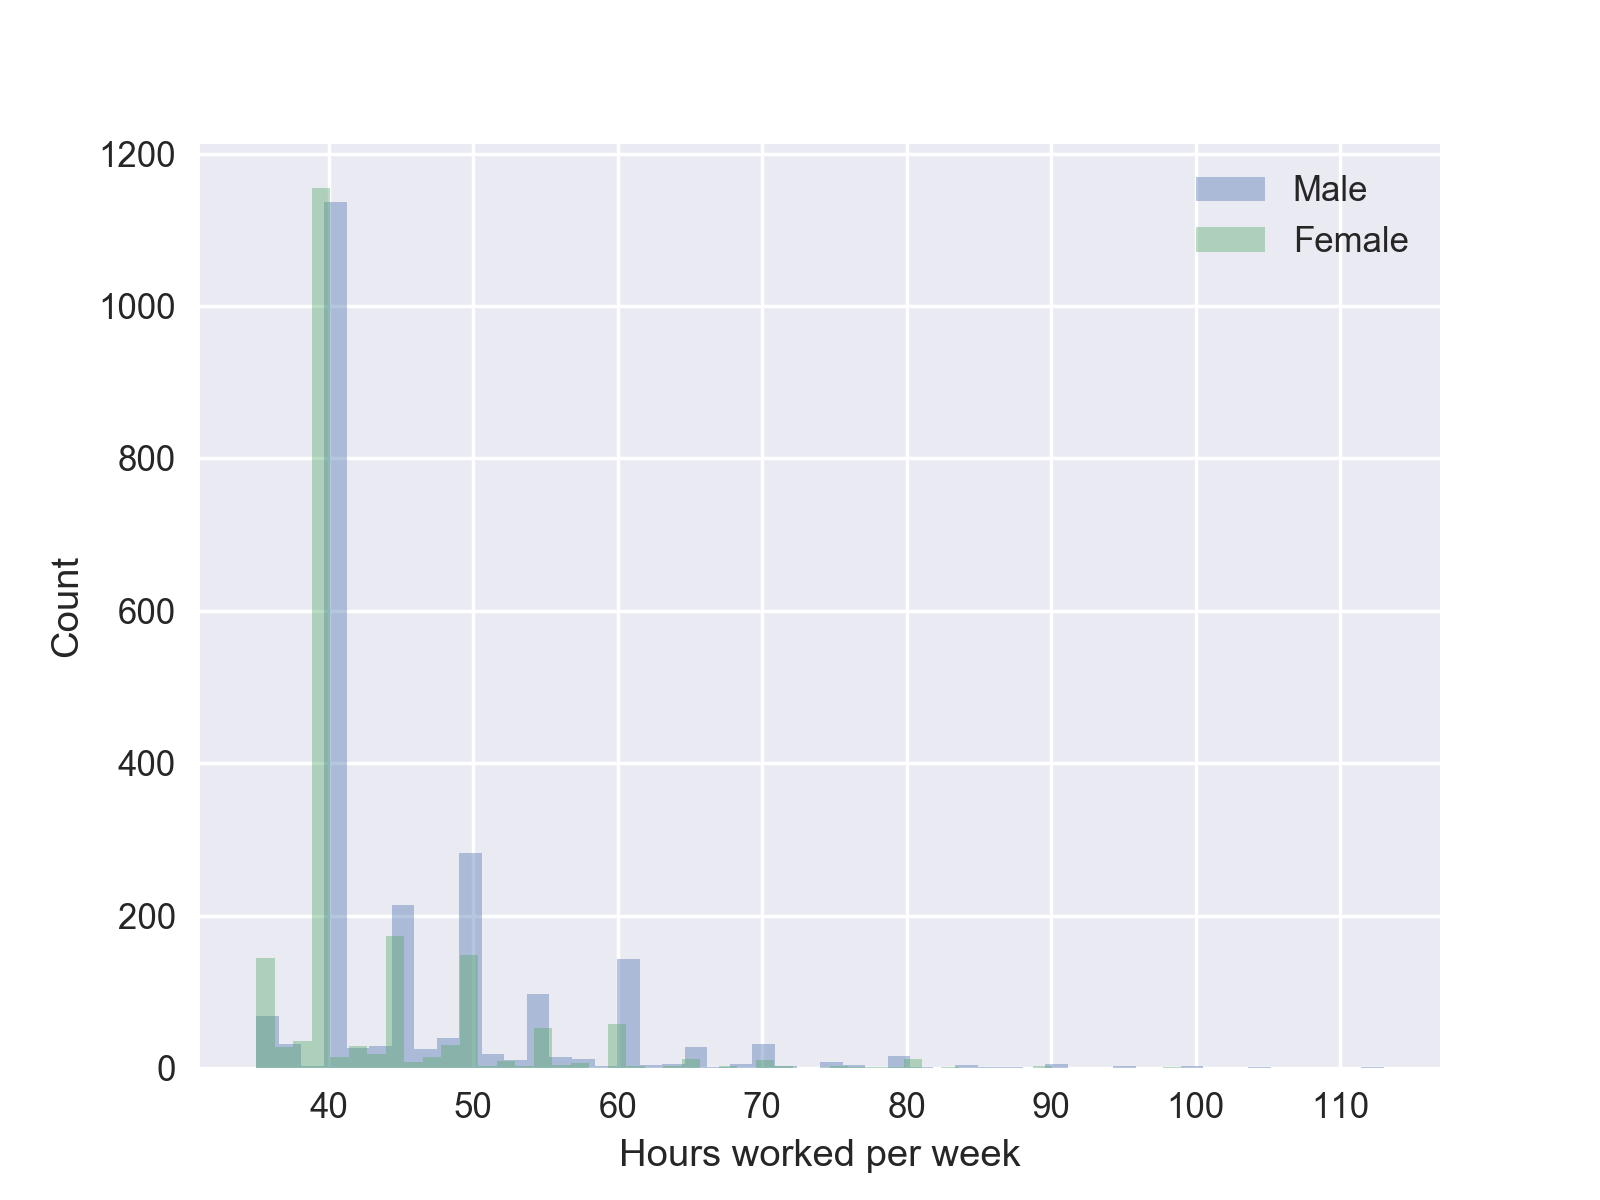

In [6]:
sns.distplot(df_employed[df_employed['TESEX'] == 1]['TEHRUSLT'] / 1., 
             kde=False, bins=50, label='Male')
sns.distplot(df_employed[df_employed['TESEX'] == 2]['TEHRUSLT'] / 1., 
             kde=False, bins=50, label='Female')
plt.legend()
plt.xlabel('Hours worked per week')
plt.ylabel('Count')
plt.show()

### How about a specific industry?

In [26]:
# business
df_w_resp = df_employed.merge(
    df_response[['TUCASEID', 'TRMJIND1']], how='left', on='TUCASEID')
df_business = df_w_resp[df_w_resp['TRMJIND1'].isin([9,])]
df_business.groupby('TESEX').agg({'TEHRUSLT': fns})

TEHRUSLT                     
         count       mean       std
TESEX                              
1          346  45.309249  7.969127
2          260  43.296154  6.993156

In [8]:
df_business['TEHRUSLT'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
TEHRUSLT,606.0,44.445545,7.625284


### Activity hours for employed
#### Sleep (all employed)

In [15]:
sleeping_cols = [x for x in df_summary.columns if x.startswith('t0101')]
df_sleep = df_employed.join(
    df_employed[sleeping_cols].sum(axis=1).to_frame('total_sleep'))

def mean_fn(x): return np.mean(x) / 60.
def std_fn(x): return np.std(x / 60.)
df_sleep.groupby('TESEX').agg({'total_sleep': 
                               ['count', mean_fn, std_fn]})

total_sleep                    
            count   mean_fn    std_fn
TESEX                                
1            2271  8.575892  2.048032
2            1990  8.690000  2.128587

In [24]:
# note the unit difference -- here we use minutes
df_sleep['total_sleep'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
total_sleep,4261.0,517.750997,125.223735


#### Sleep (business)

In [28]:
df_sleep.merge(df_business[['TUCASEID']], how='inner', on=['TUCASEID'])\
    .groupby('TESEX').agg({'total_sleep': 
                           ['count', mean_fn, std_fn]})

total_sleep                    
            count   mean_fn    std_fn
TESEX                                
1             346  8.471773  1.760404
2             260  8.694808  2.120231

In [29]:
# note the unit difference -- here we use minutes
df_sleep.merge(df_business[['TUCASEID']], how='inner', on=['TUCASEID'])\
    ['total_sleep'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
total_sleep,606.0,514.047855,115.668389


#### Housework (all employed)

In [25]:
housework_cols = [x for x in df_summary.columns 
                          if (x.startswith('t0201') 
                              or x.startswith('t0202')
                              or x.startswith('t0203'))]
df_housework = df_employed.join(
    df_employed[housework_cols].sum(axis=1).to_frame('total_housework'))
df_housework.groupby('TESEX').agg({'total_housework': 
                                 ['count', mean_fn, std_fn]})

total_housework                    
                count   mean_fn    std_fn
TESEX                                    
1                2271  0.798892  1.326651
2                1990  1.510653  1.813749

In [31]:
# note the unit difference -- here we use minutes
df_housework['total_housework'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
total_housework,4261.0,67.878198,96.767855


#### Housework (business)

In [33]:
df_housework.merge(df_business[['TUCASEID']], how='inner', on=['TUCASEID'])\
    .groupby('TESEX').agg({'total_housework': 
                           ['count', mean_fn, std_fn]})

total_housework                    
                count   mean_fn    std_fn
TESEX                                    
1                 346  0.748314  1.225232
2                 260  1.642628  1.913935

In [34]:
# note the unit difference -- here we use minutes
df_housework.merge(df_business[['TUCASEID']], how='inner', on=['TUCASEID'])\
    ['total_housework'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
total_housework,606.0,67.920792,97.285625


#### Leisure and sport (all employed)

In [37]:
leisure_and_sport_cols = [x for x in df_summary.columns 
                          if x.startswith('t12') or x.startswith('t12')]
df_l_and_s = df_employed.join(
    df_employed[leisure_and_sport_cols].sum(axis=1).to_frame('total_leisure_and_sport'))
df_l_and_s.groupby('TESEX').agg({'total_leisure_and_sport': 
                                 ['count', mean_fn, std_fn]})

total_leisure_and_sport                    
                        count   mean_fn    std_fn
TESEX                                            
1                        2271  4.117342  3.189402
2                        1990  3.564263  2.808569

In [36]:
# note the unit difference -- here we use minutes
df_l_and_s['total_leisure_and_sport'].agg(['count', np.mean, np.std]).to_frame().T

,count,mean,std
total_leisure_and_sport,4261.0,231.542361,181.828585
